<a href="https://colab.research.google.com/github/DanAkarca/modular_experts/blob/main/testing_varied_architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task Visualization:


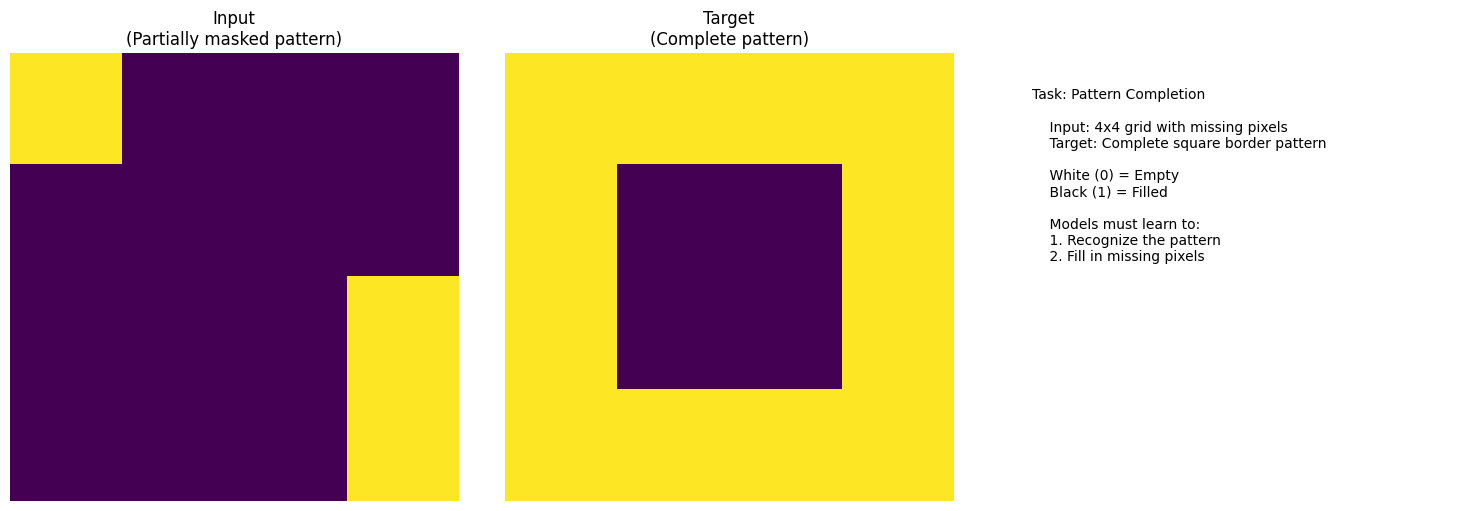


Training Models...
Epoch 0/200, Loss: 0.6880, Accuracy: 25.37%
Epoch 10/200, Loss: 0.5959, Accuracy: 26.94%
Epoch 20/200, Loss: 0.4998, Accuracy: 32.06%
Epoch 30/200, Loss: 0.3957, Accuracy: 39.00%
Epoch 40/200, Loss: 0.2890, Accuracy: 50.88%
Epoch 50/200, Loss: 0.1933, Accuracy: 66.56%
Epoch 60/200, Loss: 0.1239, Accuracy: 82.31%
Epoch 70/200, Loss: 0.0856, Accuracy: 91.37%
Epoch 80/200, Loss: 0.0677, Accuracy: 94.13%
Epoch 90/200, Loss: 0.0589, Accuracy: 95.63%
Epoch 100/200, Loss: 0.0537, Accuracy: 96.56%
Epoch 110/200, Loss: 0.0497, Accuracy: 96.81%
Epoch 120/200, Loss: 0.0461, Accuracy: 97.81%
Epoch 130/200, Loss: 0.0428, Accuracy: 98.31%
Epoch 140/200, Loss: 0.0399, Accuracy: 98.56%
Epoch 150/200, Loss: 0.0372, Accuracy: 98.75%
Epoch 160/200, Loss: 0.0346, Accuracy: 98.81%
Epoch 170/200, Loss: 0.0323, Accuracy: 99.06%
Epoch 180/200, Loss: 0.0300, Accuracy: 99.12%
Epoch 190/200, Loss: 0.0279, Accuracy: 99.25%
Epoch 0/200, Loss: 0.7799, Accuracy: 25.00%
Epoch 10/200, Loss: 0.7321,

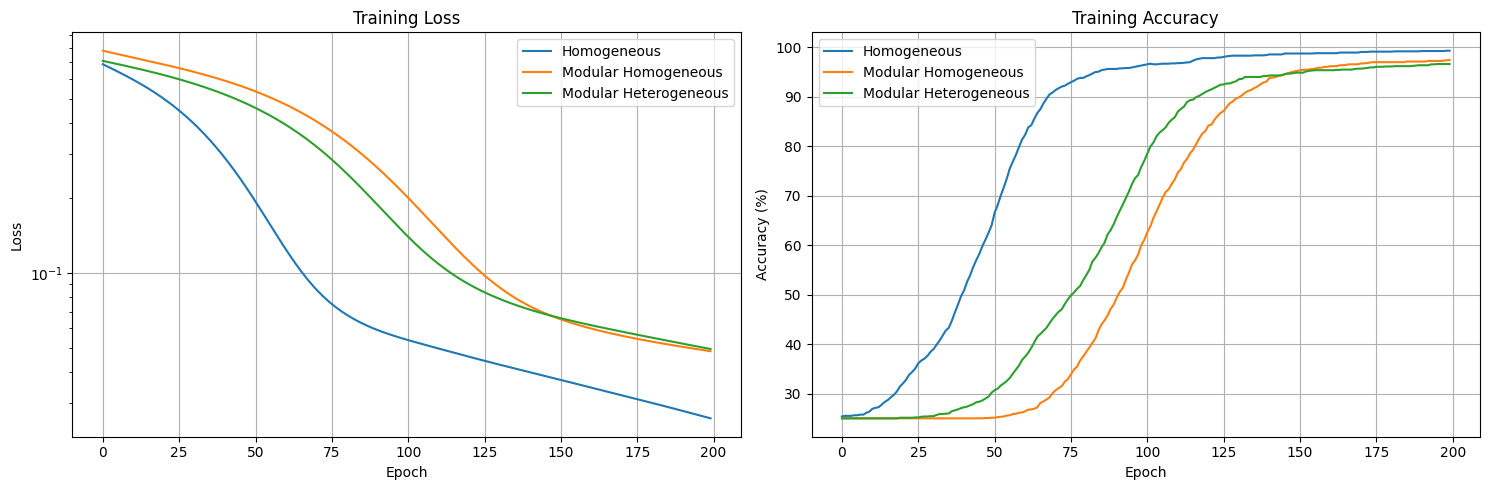


Predictions for Homogeneous:


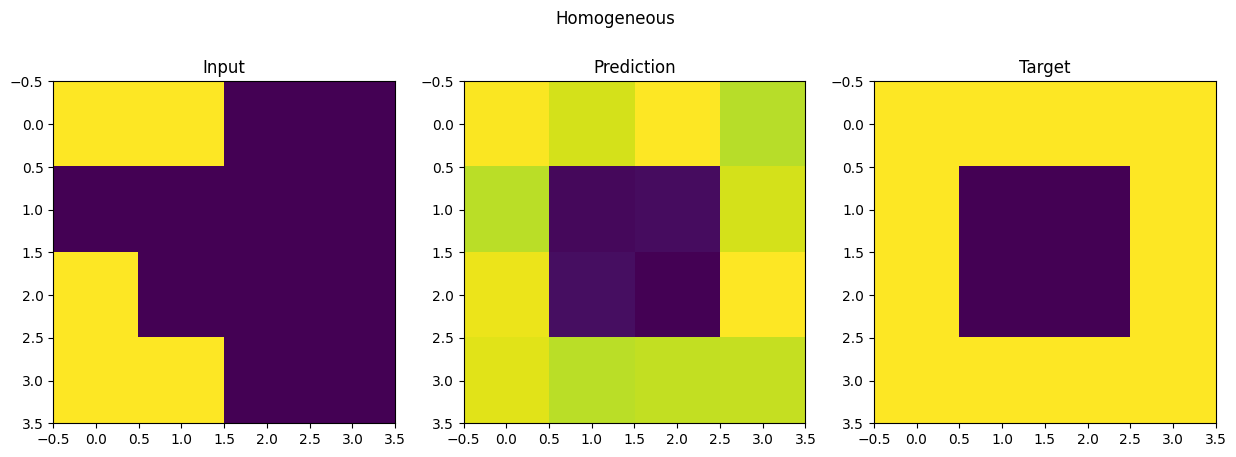


Predictions for Modular Homogeneous:


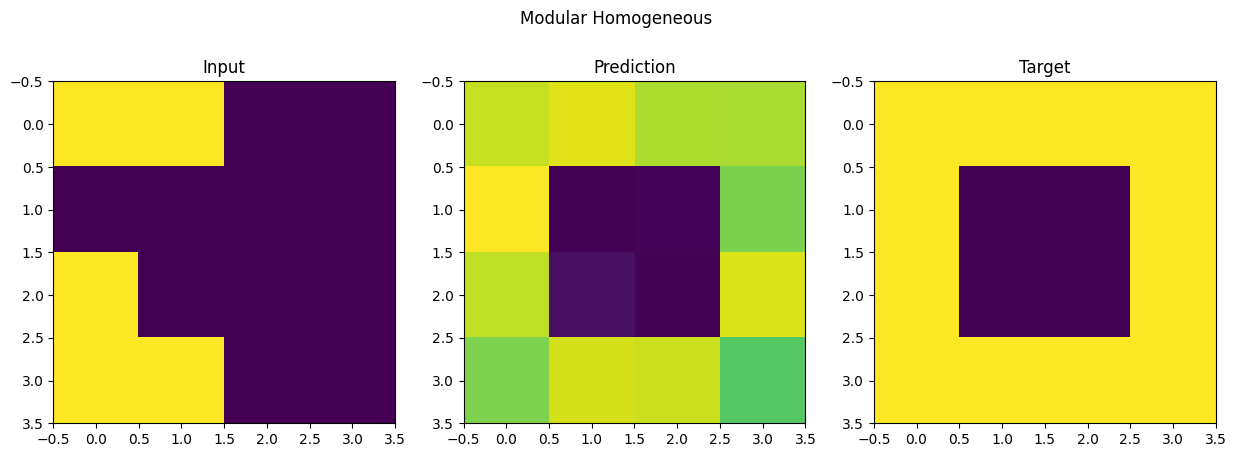


Predictions for Modular Heterogeneous:


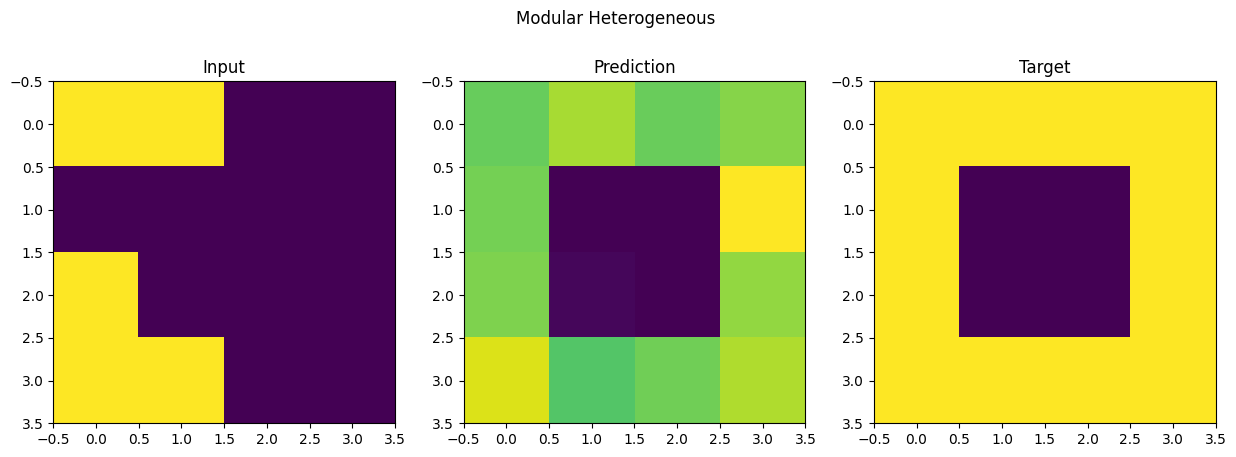

In [3]:
def visualize_task_example():
    """Visualize an example of the pattern completion task"""
    plt.figure(figsize=(15, 5))

    # Create a complete pattern
    grid_size = 4
    complete_pattern = torch.zeros((grid_size, grid_size))
    complete_pattern[0, :] = 1  # Top edge
    complete_pattern[-1, :] = 1  # Bottom edge
    complete_pattern[:, 0] = 1  # Left edge
    complete_pattern[:, -1] = 1  # Right edge

    # Create masked pattern
    masked_pattern = complete_pattern.clone()
    mask = torch.rand(grid_size, grid_size) > 0.3
    masked_pattern[mask] = 0

    # Plot
    plt.subplot(131)
    plt.imshow(masked_pattern)
    plt.title('Input\n(Partially masked pattern)')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(complete_pattern)
    plt.title('Target\n(Complete pattern)')
    plt.axis('off')

    # Add arrows and explanation
    plt.subplot(133)
    plt.text(0.1, 0.5, """Task: Pattern Completion

    Input: 4x4 grid with missing pixels
    Target: Complete square border pattern

    White (0) = Empty
    Black (1) = Filled

    Models must learn to:
    1. Recognize the pattern
    2. Fill in missing pixels
    """, fontsize=10)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def train_and_evaluate(model, train_data, train_targets, epochs=100):
    """Train model and return training history with accuracy"""
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.MSELoss()
    loss_history = []
    accuracy_history = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(train_data)
        loss = criterion(outputs, train_targets)
        loss.backward()
        optimizer.step()

        # Calculate accuracy (threshold predictions at 0.5)
        with torch.no_grad():
            predictions = (outputs > 0.5).float()
            accuracy = (predictions == train_targets).float().mean().item()
            accuracy_history.append(accuracy * 100)  # Convert to percentage
            loss_history.append(loss.item())

        if epoch % 10 == 0:  # Print progress every 10 epochs
            print(f'Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy*100:.2f}%')

    return loss_history, accuracy_history

def plot_training_metrics(histories: dict, epochs: int):
    """Plot both loss and accuracy histories"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    for name, (loss_hist, _) in histories.items():
        ax1.plot(range(epochs), loss_hist, label=name)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_yscale('log')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracy
    for name, (_, acc_hist) in histories.items():
        ax2.plot(range(epochs), acc_hist, label=name)
    ax2.set_title('Training Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Set parameters
    input_size = 16  # 4x4 grid
    total_params = 1000  # Total parameters for each model
    num_experts = 4  # Number of experts for modular networks
    num_epochs = 200  # Specify number of epochs here

    # Show task example
    print("Task Visualization:")
    visualize_task_example()

    # Generate data
    train_data, train_targets = generate_pattern_data(100)

    # Initialize models
    homogeneous = HomogeneousNetwork(input_size, total_params)
    mod_homogeneous = ModularHomogeneous(input_size, total_params, num_experts)
    expert_ratios = [0.4, 0.3, 0.2, 0.1]
    mod_heterogeneous = ModularHeterogeneous(input_size, total_params, expert_ratios)

    # Train models
    print("\nTraining Models...")
    histories = {
        'Homogeneous': train_and_evaluate(homogeneous, train_data, train_targets, num_epochs),
        'Modular Homogeneous': train_and_evaluate(mod_homogeneous, train_data, train_targets, num_epochs),
        'Modular Heterogeneous': train_and_evaluate(mod_heterogeneous, train_data, train_targets, num_epochs)
    }

    # Plot training metrics
    plot_training_metrics(histories, num_epochs)

    # Visualize predictions
    test_input, test_target = generate_pattern_data(1)

    for name, model in [('Homogeneous', homogeneous),
                       ('Modular Homogeneous', mod_homogeneous),
                       ('Modular Heterogeneous', mod_heterogeneous)]:
        print(f"\nPredictions for {name}:")
        visualize_predictions(model, test_input[0], test_target[0], title=name)